In [ ]:
# Data fetching and loading
 
import pandas as pd
data_path = '/content/drive/My Drive/covid-19'
metadata_path = '/content/drive/My Drive/covid-19/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,10-01-2014,Samuel Minot; Stephen D Turner; Krista L Ternu...,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/001727
1,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,04-06-2014,Lin WANG; Xiang Li,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/003889
2,62gfisc6,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,biorxiv,Sequencing of the human IG light chain loci fr...,10.1101/006866,NaN,NaN,biorxiv,Germline variation at immunoglobulin gene (IG)...,03-07-2014,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/006866
3,058r9486,4da8a87e614373d56070ed272487451266dce919,biorxiv,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,NaN,NaN,biorxiv,Deep sequencing of clinical samples is now an ...,25-07-2014,Sofia Morfopoulou; Vincent Plagnol,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/007476
4,wich35l7,eccef80cfbe078235df22398f195d5db462d8000,biorxiv,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,NaN,NaN,biorxiv,Developing methods to reconstruct transmission...,11-11-2014,Stephen P Velsko; Jonathan E Allen,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/010389


In [ ]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852 entries, 0 to 1851
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cord_uid                     1852 non-null   object 
 1   sha                          1625 non-null   object 
 2   source_x                     1852 non-null   object 
 3   title                        1852 non-null   object 
 4   doi                          1852 non-null   object 
 5   pmcid                        0 non-null      float64
 6   pubmed_id                    0 non-null      object 
 7   license                      1852 non-null   object 
 8   abstract                     1851 non-null   object 
 9   publish_time                 1852 non-null   object 
 10  authors                      1852 non-null   object 
 11  journal                      0 non-null      float64
 12  Microsoft Academic Paper ID  0 non-null      object 
 13  WHO #Covidence    

Reading json files for body-text data

In [ ]:
import glob

all_json = glob.glob(f'{data_path}/**/*.json', recursive=True)
len(all_json)

1635

In [ ]:
import json

class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []

            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
                
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

b915b88096b8bfd15199b71087479466308bd5ce: Many of the proteins produced by SARS-CoV-2 have related counterparts across the Severe Acute Respiratory Syndrome (SARS-CoV) family. One such protein is non-structural protein 9 (Nsp9), which is thou... Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) is comprised of a large single stranded positive polarity RNA genome that acts as messenger RNA after entering the host. Post infection, th...


In [ ]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

Loading the body-text data from json to DataFrame

In [ ]:
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 100 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # if more than 2 authors, take them all with html tag breaks in between
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 1635
Processing index: 163 of 1635
Processing index: 326 of 1635
Processing index: 489 of 1635
Processing index: 652 of 1635
Processing index: 815 of 1635
Processing index: 978 of 1635
Processing index: 1141 of 1635
Processing index: 1304 of 1635
Processing index: 1467 of 1635
Processing index: 1630 of 1635


,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary
0,b915b88096b8bfd15199b71087479466308bd5ce,10.1101/2020.03.28.013920,Many of the proteins produced by SARS-CoV-2 ha...,Severe acute respiratory syndrome coronavirus ...,Dene Littler. Benjamin Gully. Rhys N Colson...,Crystal structure of the SARS-CoV-2<br>non-st...,NaN,Many of the proteins produced by SARS-CoV-2<b...
1,b900117588b0abcf57225ad57576cbee173865e4,10.1101/2020.03.28.013607,The outbreak of COVID-19 has now become a glob...,The continuing pandemic of coronavirus disease...,Xiaoqiang Huang. Robin Pearce. Yang Zhang,Computational Design of Peptides to Block<br>...,NaN,The outbreak of COVID-19 has now become a glo...
2,b9c285b9be5524a8d241c0a32a1cb1ef9df155f6,10.1101/2020.03.19.20037192,,"The COVID-19 pandemic [3] , recorded daily by ...",Albertine Weber. Flavio Iannelli. Sebastian...,Trend analysis of the COVID-19 pandemic in<br...,NaN,Not provided.
3,b9d60252e3a47fc91f96ff8cf1c65c2a9e3fdf93,10.1101/2020.03.23.20038331,,"In late December 2019, researchers identified ...",Tigist Ferede Menkir. Taylor Chin. James A ...,Estimating the number of undetected COVID-19<...,NaN,Not provided.
4,b9dbb79c9e06164c3b7fefce67c11c5d6caf1fcd,10.1101/2020.01.29.925354,"Viruses evolve extremely quickly, so reliable ...",Within a globally interconnected and densely p...,Jakub M Bartoszewicz. Anja Seidel. Bernhard...,Interpretable detection of novel human<br>vir...,NaN,"Viruses evolve extremely quickly, so reliable..."


Calculating the word count and unique word count

In [ ]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,b915b88096b8bfd15199b71087479466308bd5ce,10.1101/2020.03.28.013920,Many of the proteins produced by SARS-CoV-2 ha...,Severe acute respiratory syndrome coronavirus ...,Dene Littler. Benjamin Gully. Rhys N Colson...,Crystal structure of the SARS-CoV-2<br>non-st...,NaN,Many of the proteins produced by SARS-CoV-2<b...,181,3254,1258
1,b900117588b0abcf57225ad57576cbee173865e4,10.1101/2020.03.28.013607,The outbreak of COVID-19 has now become a glob...,The continuing pandemic of coronavirus disease...,Xiaoqiang Huang. Robin Pearce. Yang Zhang,Computational Design of Peptides to Block<br>...,NaN,The outbreak of COVID-19 has now become a glo...,310,3999,1166
2,b9c285b9be5524a8d241c0a32a1cb1ef9df155f6,10.1101/2020.03.19.20037192,,"The COVID-19 pandemic [3] , recorded daily by ...",Albertine Weber. Flavio Iannelli. Sebastian...,Trend analysis of the COVID-19 pandemic in<br...,NaN,Not provided.,0,3241,985
3,b9d60252e3a47fc91f96ff8cf1c65c2a9e3fdf93,10.1101/2020.03.23.20038331,,"In late December 2019, researchers identified ...",Tigist Ferede Menkir. Taylor Chin. James A ...,Estimating the number of undetected COVID-19<...,NaN,Not provided.,0,4626,1178
4,b9dbb79c9e06164c3b7fefce67c11c5d6caf1fcd,10.1101/2020.01.29.925354,"Viruses evolve extremely quickly, so reliable ...",Within a globally interconnected and densely p...,Jakub M Bartoszewicz. Anja Seidel. Bernhard...,Interpretable detection of novel human<br>vir...,NaN,"Viruses evolve extremely quickly, so reliable...",142,5314,1763


In [ ]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1635 entries, 0 to 1634
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   paper_id             1635 non-null   object 
 1   doi                  1635 non-null   object 
 2   abstract             1635 non-null   object 
 3   body_text            1635 non-null   object 
 4   authors              1635 non-null   object 
 5   title                1635 non-null   object 
 6   journal              0 non-null      float64
 7   abstract_summary     1635 non-null   object 
 8   abstract_word_count  1635 non-null   int64  
 9   body_word_count      1635 non-null   int64  
 10  body_unique_words    1635 non-null   int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 140.6+ KB


Removing duplicates

In [ ]:
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

count     1624
unique    1406
top           
freq       215
Name: abstract, dtype: object

In [ ]:
df_covid['body_text'].describe(include='all')

count                                                  1624
unique                                                 1624
top       Beginning from Dec. 2019, an outbreak of pneum...
freq                                                      1
Name: body_text, dtype: object

In [ ]:
df_covid.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,b915b88096b8bfd15199b71087479466308bd5ce,10.1101/2020.03.28.013920,Many of the proteins produced by SARS-CoV-2 ha...,Severe acute respiratory syndrome coronavirus ...,Dene Littler. Benjamin Gully. Rhys N Colson...,Crystal structure of the SARS-CoV-2<br>non-st...,NaN,Many of the proteins produced by SARS-CoV-2<b...,181,3254,1258
1,b900117588b0abcf57225ad57576cbee173865e4,10.1101/2020.03.28.013607,The outbreak of COVID-19 has now become a glob...,The continuing pandemic of coronavirus disease...,Xiaoqiang Huang. Robin Pearce. Yang Zhang,Computational Design of Peptides to Block<br>...,NaN,The outbreak of COVID-19 has now become a glo...,310,3999,1166
2,b9c285b9be5524a8d241c0a32a1cb1ef9df155f6,10.1101/2020.03.19.20037192,,"The COVID-19 pandemic [3] , recorded daily by ...",Albertine Weber. Flavio Iannelli. Sebastian...,Trend analysis of the COVID-19 pandemic in<br...,NaN,Not provided.,0,3241,985
3,b9d60252e3a47fc91f96ff8cf1c65c2a9e3fdf93,10.1101/2020.03.23.20038331,,"In late December 2019, researchers identified ...",Tigist Ferede Menkir. Taylor Chin. James A ...,Estimating the number of undetected COVID-19<...,NaN,Not provided.,0,4626,1178
4,b9dbb79c9e06164c3b7fefce67c11c5d6caf1fcd,10.1101/2020.01.29.925354,"Viruses evolve extremely quickly, so reliable ...",Within a globally interconnected and densely p...,Jakub M Bartoszewicz. Anja Seidel. Bernhard...,Interpretable detection of novel human<br>vir...,NaN,"Viruses evolve extremely quickly, so reliable...",142,5314,1763


In [ ]:
df_covid.describe()

,journal,abstract_word_count,body_word_count,body_unique_words
count,0.0,1624.000000,1624.000000,1624.000000
mean,NaN,232.176724,2987.612685,945.836823
std,NaN,320.505537,2280.350545,479.621273
min,NaN,0.000000,174.000000,87.000000
25%,NaN,87.000000,1621.250000,620.500000
50%,NaN,184.000000,2525.500000,861.500000
75%,NaN,268.000000,3728.250000,1169.000000
max,NaN,4170.000000,44741.000000,4132.000000


In [ ]:
# Randomly selecting 10,000 research papers in case of loading large data
# df = df_covid.sample(10000, random_state=42)
# del df_covid

df = df_covid.copy()
df.head()
# df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1624 entries, 0 to 1634
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   paper_id             1624 non-null   object 
 1   doi                  1624 non-null   object 
 2   abstract             1624 non-null   object 
 3   body_text            1624 non-null   object 
 4   authors              1624 non-null   object 
 5   title                1624 non-null   object 
 6   journal              0 non-null      float64
 7   abstract_summary     1624 non-null   object 
 8   abstract_word_count  1624 non-null   int64  
 9   body_word_count      1624 non-null   int64  
 10  body_unique_words    1624 non-null   int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 152.2+ KB


Language detection and removing non English literatures

In [ ]:
!pip install langdetect
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

print(len(df))

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

print(languages)

     |████████████████████████████████| 983kB 4.6MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993193 sha256=13b4cdbbd556a49522b203ee5d9ce8fcf2f2d496929080ce172b79cc6b9ca40a
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


  0%|          | 0/1624 [00:00<?, ?it/s]

1624


100%|██████████| 1624/1624 [00:09<00:00, 174.82it/s]

['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en

In [ ]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 1624

{'cy': 5, 'en': 1618, 'it': 1}


In [ ]:
df['language'] = languages
df = df[df['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1618 entries, 0 to 1634
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   paper_id             1618 non-null   object 
 1   doi                  1618 non-null   object 
 2   abstract             1618 non-null   object 
 3   body_text            1618 non-null   object 
 4   authors              1618 non-null   object 
 5   title                1618 non-null   object 
 6   journal              0 non-null      float64
 7   abstract_summary     1618 non-null   object 
 8   abstract_word_count  1618 non-null   int64  
 9   body_word_count      1618 non-null   int64  
 10  body_unique_words    1618 non-null   int64  
 11  language             1618 non-null   object 
dtypes: float64(1), int64(3), object(8)
memory usage: 164.3+ KB


NLP operations: tokenization and removing stop words

In [ ]:
# Download the spacy bio parser

from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

In [ ]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step

In [ ]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['perhaps',
 'already',
 're',
 'what',
 'and',
 'whenever',
 'less',
 'how',
 'beside',
 'side']

In [ ]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [ ]:
# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [ ]:
tqdm.pandas()
df["processed_text"] = df["body_text"].progress_apply(spacy_tokenizer)

100%|██████████| 1618/1618 [07:09<00:00,  3.77it/s]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


count     1618.000000
mean      2988.550680
std       2281.477619
min        174.000000
25%       1622.500000
50%       2525.500000
75%       3728.750000
max      44741.000000
Name: body_word_count, dtype: float64

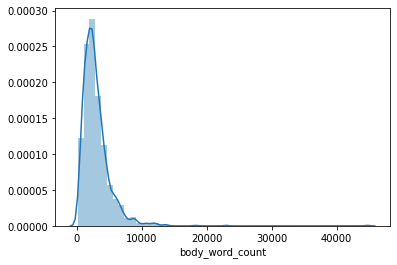

In [ ]:
import seaborn as sns
sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

count    1618.000000
mean      948.459209
std       478.376951
min        95.000000
25%       624.250000
50%       862.500000
75%      1169.750000
max      4132.000000
Name: body_unique_words, dtype: float64

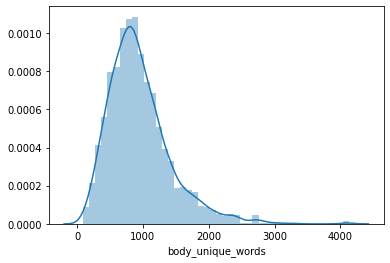

In [ ]:
sns.distplot(df['body_unique_words'])
df['body_unique_words'].describe()

Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

Deciding number of features

In [ ]:
text = df['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(1618, 4096)

Running PCA to find optimal number of features

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(1618, 1029)

Elbow method to decide optimal k value (i.e. number of clusters)

In [ ]:
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np


# run kmeans with many different k
distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

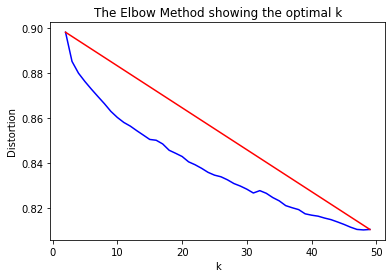

In [ ]:
import matplotlib.pyplot as plt
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Designing Autoencoder

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model

def autoencoder(dims, act='relu', init='glorot_uniform'):
    n_stacks = len(dims) - 1
    
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    
    # internal layers of encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act,  kernel_initializer=init, name='encoder_%d' % i)(x)
    # latent hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)
    x = encoded
    # internal layers of decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)
    # decoder output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    
    decoded = x
    
    autoencoder_model = Model(inputs=input_data, outputs=decoded, name='autoencoder')
    encoder_model     = Model(inputs=input_data, outputs=encoded, name='encoder')
    
    return autoencoder_model, encoder_model

In [ ]:
import tensorflow as tf
from keras import optimizers, initializers

n_epochs   = 100
batch_size = 128
dims = [X.shape[-1], 2000, 1000, 2000, 1000] 
init = initializers.VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = optimizers.SGD(lr=1, momentum=0.9)
pretrain_epochs = n_epochs
batch_size = batch_size
save_dir = './results'
autoencoder, encoder = autoencoder(dims, init=init)

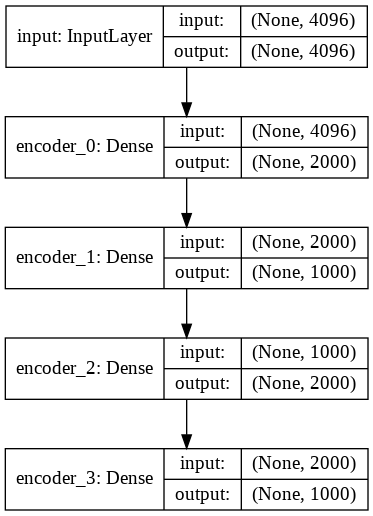

In [ ]:
from keras.utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='encoder.png')

Training Autoencoder

In [ ]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(X, X, batch_size=batch_size, epochs=pretrain_epochs)
autoencoder.save_weights('/ae_weights.h5')

Epoch 1/100
1618/1618 [==============================] - 7s 5ms/step - loss: 2.4353e-04
Epoch 2/100
1618/1618 [==============================] - 7s 4ms/step - loss: 2.4094e-04
Epoch 3/100
1618/1618 [==============================] - 7s 4ms/step - loss: 2.3781e-04
Epoch 4/100
1618/1618 [==============================] - 7s 4ms/step - loss: 2.3489e-04
Epoch 5/100
1618/1618 [==============================] - 7s 4ms/step - loss: 2.3233e-04
Epoch 6/100
1618/1618 [==============================] - 7s 4ms/step - loss: 2.3014e-04
Epoch 7/100
1618/1618 [==============================] - 7s 4ms/step - loss: 2.2826e-04
Epoch 8/100
1618/1618 [==============================] - 7s 4ms/step - loss: 2.2665e-04
Epoch 9/100
1618/1618 [==============================] - 7s 4ms/step - loss: 2.2527e-04
Epoch 10/100
1618/1618 [==============================] - 7s 4ms/step - loss: 2.2407e-04
Epoch 11/100
1618/1618 [==============================] - 7s 4ms/step - loss: 2.2304e-04
Epoch 12/100
1618/1618 [======

In [ ]:
autoencoder.load_weights('/ae_weights.h5')

Designing clustering layer

In [ ]:
from keras.layers import Layer, InputSpec
from keras import backend as K

class ClusteringLayer(Layer):
    
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)
    
    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters', shape=(self.n_clusters, input_dim), initializer='glorot_uniform') 
        
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True
    
    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) 
        
        return q
    
    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters
    
    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
n_clusters = 12
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

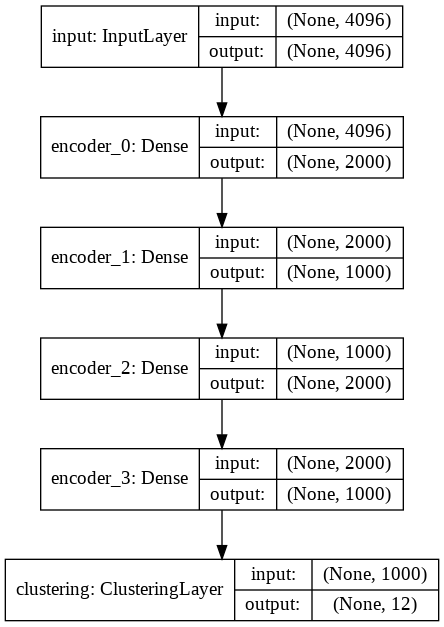

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 4096)              0         
_________________________________________________________________
encoder_0 (Dense)            (None, 2000)              8194000   
_________________________________________________________________
encoder_1 (Dense)            (None, 1000)              2001000   
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              2002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 1000)              2001000   
_________________________________________________________________
clustering (ClusteringLayer) (None, 12)                12000     
Total params: 14,210,000
Trainable params: 14,210,000
Non-trainable params: 0
_______________________________________________

Initializing clustering layer with weights obtained from k-means method

In [ ]:
from sklearn.cluster import KMeans
model.compile(optimizer=optimizers.SGD(0.01, 0.9), loss='kld')
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
y_pred = kmeans.fit_predict(encoder.predict(X))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

In [ ]:
import numpy as np

# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

loss = 0
index = 0
maxiter = 1000 
update_interval = 100 
tol = 0.001 # tolerance threshold to stop training
index_array = np.arange(X.shape[0])

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(X, verbose=0)
        p = target_distribution(q)

    idx = index_array[index * batch_size: min((index+1) * batch_size, X.shape[0])]
    loss = model.train_on_batch(x=X.toarray()[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= X.shape[0] else 0

model.save_weights('/DEC_model_final.h5')
model.load_weights('/DEC_model_final.h5')

t-SNE method to plot data on two dimension graph

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1618 samples in 0.674s...
[t-SNE] Computed neighbors for 1618 samples in 23.392s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1618
[t-SNE] Computed conditional probabilities for sample 1618 / 1618
[t-SNE] Mean sigma: 0.335828
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.276039
[t-SNE] KL divergence after 1000 iterations: 1.072846


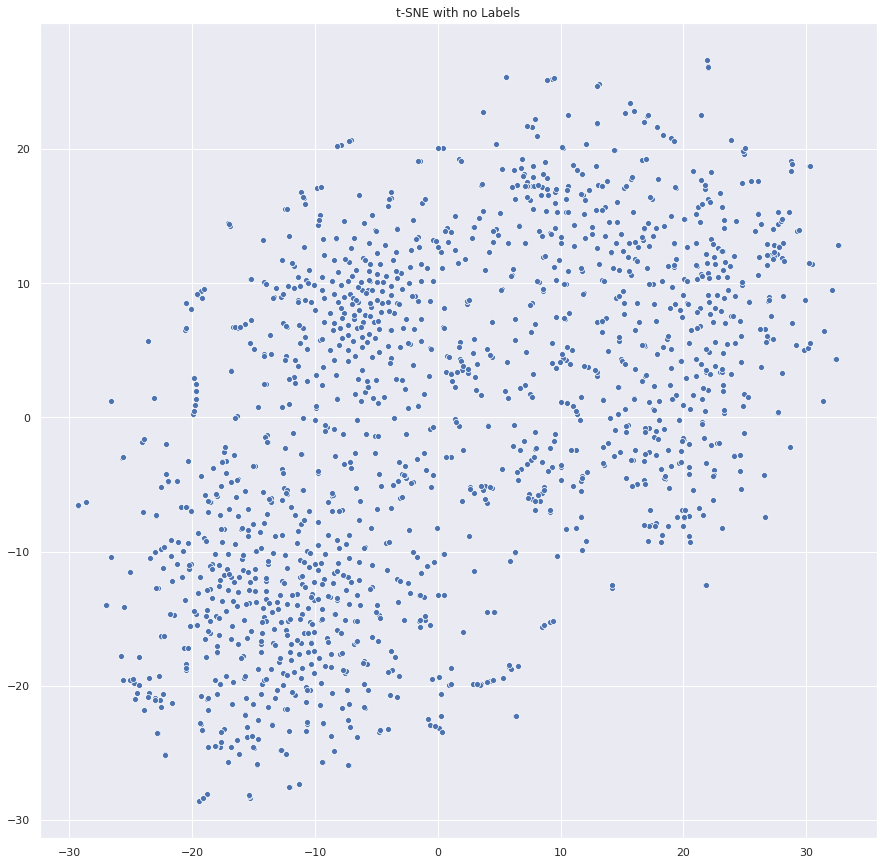

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

Clustering using designed model (autoencoder + clustering layer)

In [ ]:
q = model.predict(X, verbose=0)
p = target_distribution(q)  
y_pred = q.argmax(1)
df['y'] = y_pred

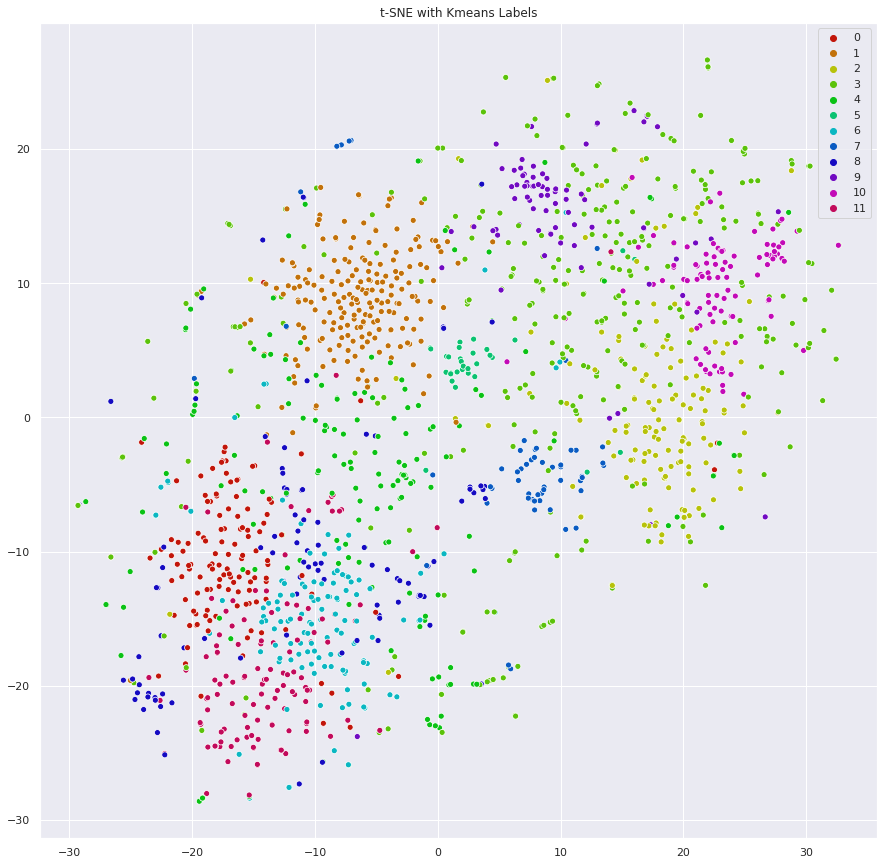

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(12, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

Evaluation using silhouette method

In [ ]:
from sklearn.metrics import silhouette_score
score = silhouette_score(X, y_pred, metric='euclidean')
print(score)

0.011007505607566937


Check clustering using supervised method

In [ ]:
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

In [ ]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_pred, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 1294
X_test size: 324 



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  74.189 %
     Precision:  74.139 %
        Recall:  72.644 %
      F1 score:  72.814 %


In [ ]:
# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_test, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  70.988 %
     Precision:  72.320 %
        Recall:  69.726 %
      F1 score:  69.998 %


In [ ]:
sgd_cv_score = cross_val_score(sgd_clf, X.toarray(), y_pred, cv=10)
print("Mean cv Score - SGD: {:,.3f}".format(float(sgd_cv_score.mean()) * 100), "%")

Mean cv Score - SGD: 78.370 %
